### Detection of fraudulent transactions in a credit card dataset.

In [ ]:
#import important library
import shap
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mlflow.sklearn.autolog()

In [ ]:
#load the data from local path
df = pd.read_csv('c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/Preprocessed_Creditcard_Data.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,time_in_days,Amount_scaled
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.000000,0.244200
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.000000,-0.342584
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.000012,1.158900
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.000012,0.139886
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.000023,-0.073813


Class
0    283253
1       473
Name: count, dtype: int64


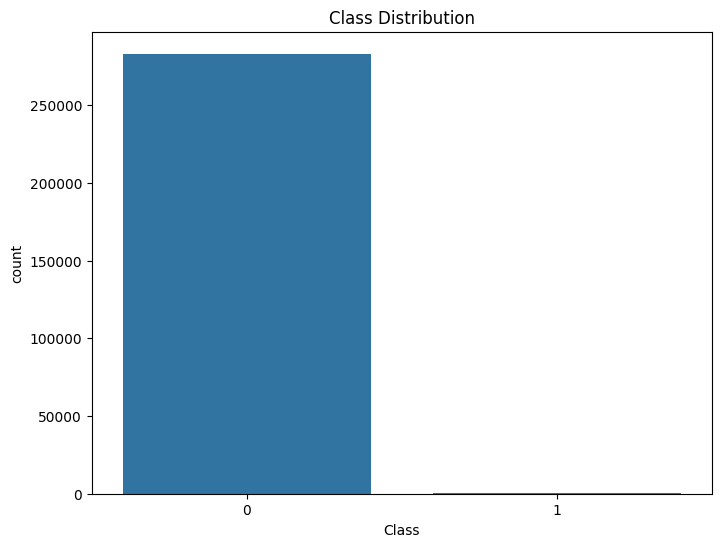

In [4]:
# Visualize Class distribution
class_counts = df['Class'].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.show()

In [ ]:
# split 
X = df.drop('Class', axis=1)
y = df['Class']

##### Using SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic data

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train = X_resampled
y_train = y_resampled

class_counts = y_train.value_counts()
print(class_counts)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Class
0    283253
1    283253
Name: count, dtype: int64


In [23]:
X_train.columns.tolist() 

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'time_in_days',
 'Amount_scaled']

In [ ]:
# scaling the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# tracking with mlflow
import os 
import joblib
# saving the models
save_folder = 'c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/Fraud_detection/credit-model'
os.makedirs(save_folder, exist_ok=True) 

# Function to save scikit-learn models
def save_sklearn_model(model, model_name):
    save_path = os.path.join(save_folder, f'{model_name}.joblib')
    joblib.dump(model, save_path)
    print(f'{model_name} saved at {save_path}')


In [10]:
# Function to log experiments with MLflow
def log_experiment(model_name, model, X_train, X_test, y_train, y_test, params=None):
    with mlflow.start_run(run_name=model_name):
        # Fit the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Log parameters if provided
        if params:
            for key, value in params.items():
                mlflow.log_param(key, value)
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        # Log the model
        mlflow.sklearn.log_model(model, model_name)
        
        print(f"Model: {model_name}")
        print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
        save_sklearn_model(model, model_name)
        print('model saved')

In [11]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_experiment("Logistic Regression", log_reg, X_train, X_test, y_train, y_test, 
               params={"max_iter": 1000})

2024/10/24 10:51:57 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2024/10/24 10:52:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Logistic Regression
Accuracy: 0.9790294963901784, Precision: 0.9906311370556546, Recall: 0.9673463642921234, F1 Score: 0.9788502964163003
Logistic Regression saved at C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/saved_models\Logistic Regression.joblib
model saved


In [12]:
# Random Forest
rand_forest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
log_experiment("Random Forest", rand_forest, X_train, X_test, y_train, y_test, 
               params={"n_estimators": 100, "max_depth": 10})


2024/10/24 10:52:25 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2024/10/24 10:58:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Random Forest
Accuracy: 0.9915623731266879, Precision: 0.9987327086122267, Recall: 0.984429704956104, F1 Score: 0.9915296285795293
Random Forest saved at C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/saved_models\Random Forest.joblib
model saved


##### Training a Gradient Boosting Model

In [13]:
# Gradient Boosting
grad_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
log_experiment("Gradient Boosting", grad_boost, X_train, X_test, y_train, y_test, 
               params={"n_estimators": 100, "learning_rate": 0.1})

2024/10/24 10:59:35 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2024/10/24 11:11:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Gradient Boosting
Accuracy: 0.9863550511023635, Precision: 0.9937492186523316, Recall: 0.9789581097485881, F1 Score: 0.9862982132728304
Gradient Boosting saved at C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/saved_models\Gradient Boosting.joblib
model saved


In [14]:
# Decision Tree
dec_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
log_experiment("Decision Tree", dec_tree, X_train, X_test, y_train, y_test, 
               params={"max_depth": 5})

2024/10/24 11:11:14 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2024/10/24 11:11:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Decision Tree
Accuracy: 0.9685177666766694, Precision: 0.9810720994076001, Recall: 0.9556818381744928, F1 Score: 0.9682105394494105
Decision Tree saved at C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/saved_models\Decision Tree.joblib
model saved


### Model Explanability using shap

In [20]:
import shap
import mlflow
import joblib
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def log_experiment_with_shap(model_name, model, X_train, X_test, y_train, y_test, params=None):
    # Ensure X_train and X_test are DataFrames to access feature names
    if not isinstance(X_train, pd.DataFrame):
        raise ValueError("X_train must be a pandas DataFrame.")
    if not isinstance(X_test, pd.DataFrame):
        raise ValueError("X_test must be a pandas DataFrame.")

    with mlflow.start_run(run_name=model_name):
        
        # SHAP Explanation for Logistic Regression using KernelExplainer
        if model_name == "Logistic Regression":
            # Use KernelExplainer for Logistic Regression
            background = shap.sample(X_train, 100)  # Sampling a smaller set for the background
            explainer = shap.KernelExplainer(model.predict, background)
            
            # Subsample the test set to handle large data (optional for memory efficiency)
            X_test_sample = X_test.sample(n=100, random_state=42)

            # Get SHAP values
            shap_values = explainer.shap_values(X_test_sample)
            
            # Summary plot with feature names
            shap.summary_plot(shap_values, X_test_sample, plot_type="bar", feature_names=X_test.columns)

        elif model_name in ["Gradient Boosting", "Random Forest", "Decision Tree"]:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
            
            # Summary plot with feature names
            shap.summary_plot(shap_values, X_test, max_display=32, feature_names=X_test.columns)

        # Logging metrics
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Log parameters and metrics to MLflow
        if params:
            mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)
        
        print(f"Model: {model_name} | Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1 Score: {f1:.4f}")

##### Logistic regression

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\sklearn\linear_model\_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\sklearn\linear_model\_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
  1%|          | 1/100 [00:00<00:55,  1.77it/s]c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\sklearn\linear_model\_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\sklearn\linear_model\_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
  2%|▏         | 2/100 [00:01<00:58,  1.67it/s]c:\Users\elbet\miniconda3\envs\elbetel\lib\site-package

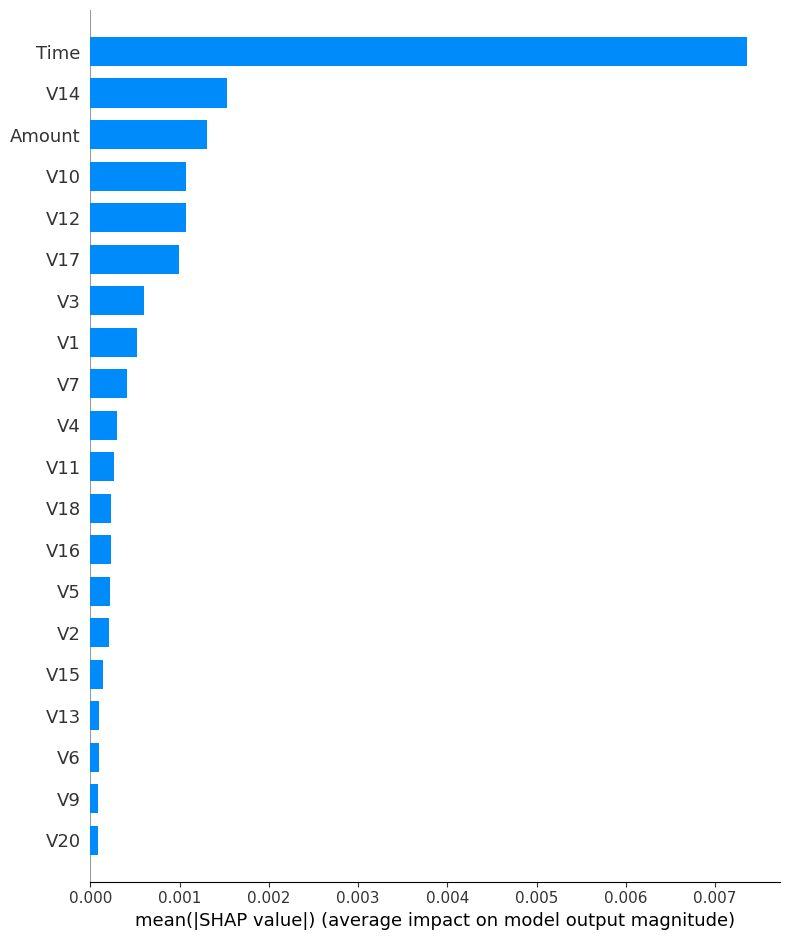

c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Model: Logistic Regression | Accuracy: 0.4982 | Precision: 0.4737 | Recall: 0.0017 | F1 Score: 0.0035


In [ ]:
model_name = "Logistic Regression"
model_path = "c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/fraud_detection/credit-model/Logistic Regression.joblib"  
model = joblib.load(model_path)

log_experiment_with_shap(
    model_name=model_name,
    model=model,
    X_train=X_train,         
    X_test=X_test,          
    y_train=y_train,         
    y_test=y_test,          
    params={"C": 1.0}        
)

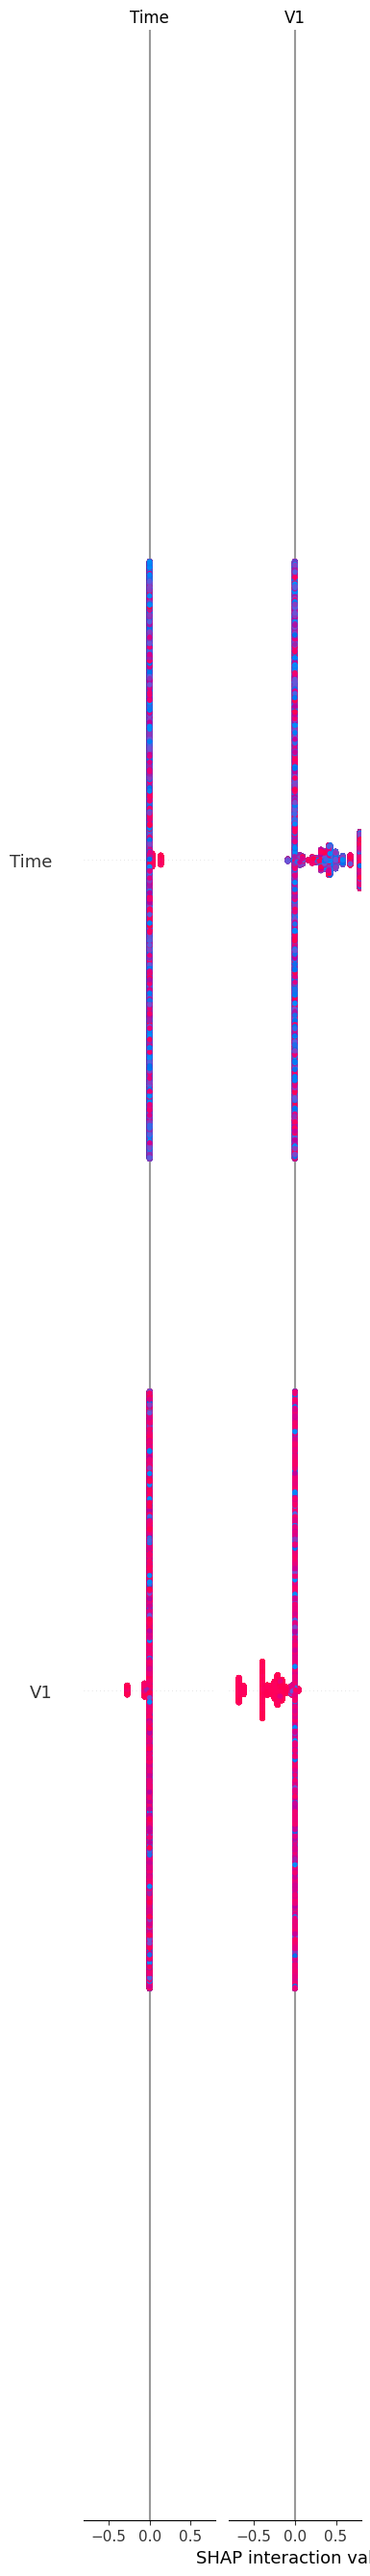

Model: Decision Tree | Accuracy: 0.7096 | Precision: 0.6351 | Recall: 0.9897 | F1 Score: 0.7737


c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# decision tree model
model_name = "Decision Tree"
model_path = "c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/fraud_detection/credit-model/Decision Tree.joblib"  
model = joblib.load(model_path)

log_experiment_with_shap(
    model_name=model_name,
    model=model,
    X_train=X_train,         
    X_test=X_test,          
    y_train=y_train,         
    y_test=y_test,          
    params={"max_depth": 10}       
)

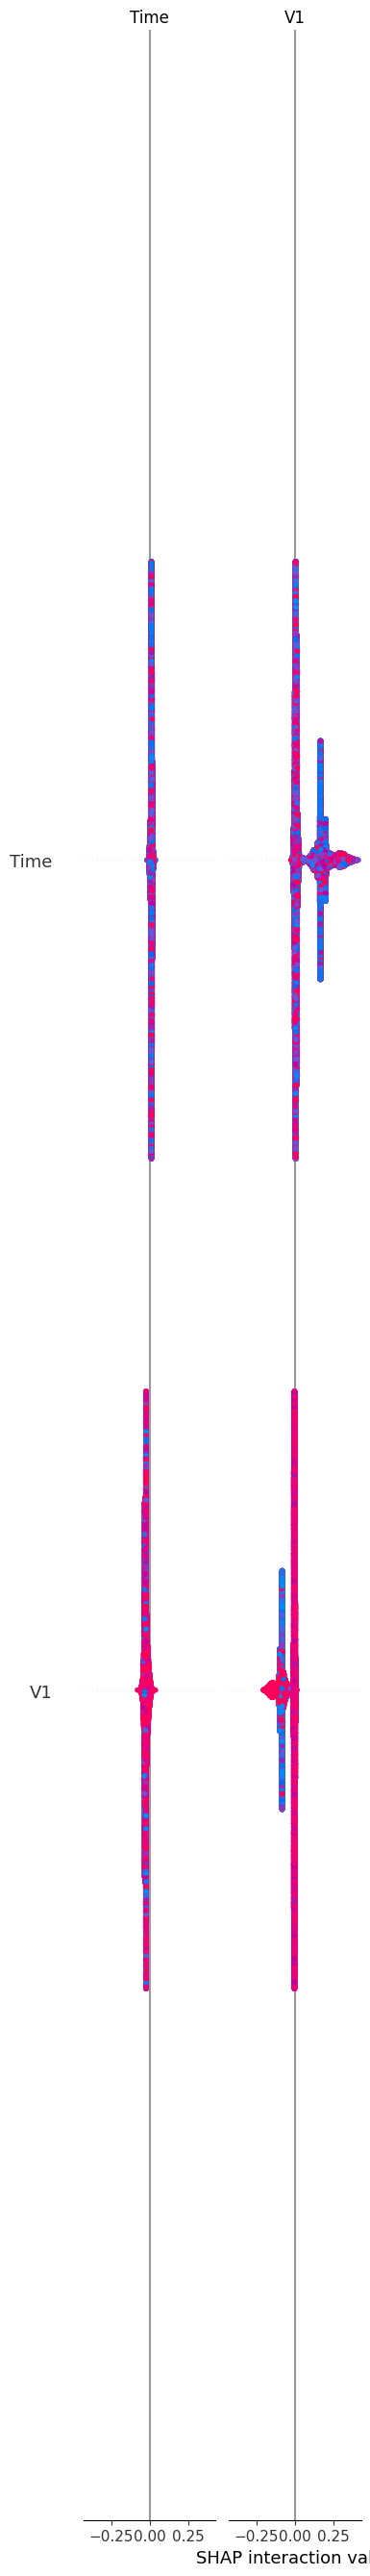

c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Model: Random Forest | Accuracy: 0.7626 | Precision: 0.7444 | Recall: 0.8022 | F1 Score: 0.7722


In [ ]:
# Random Forest
model_name = "Random Forest"
model_path = "c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/fraud_detection/credit-model/Random Forest.joblib"  
model = joblib.load(model_path)

log_experiment_with_shap(
    model_name=model_name,
    model=model,
    X_train=X_train,         
    X_test=X_test,          
    y_train=y_train,         
    y_test=y_test,          
    params={"n_estimators": 100}
)

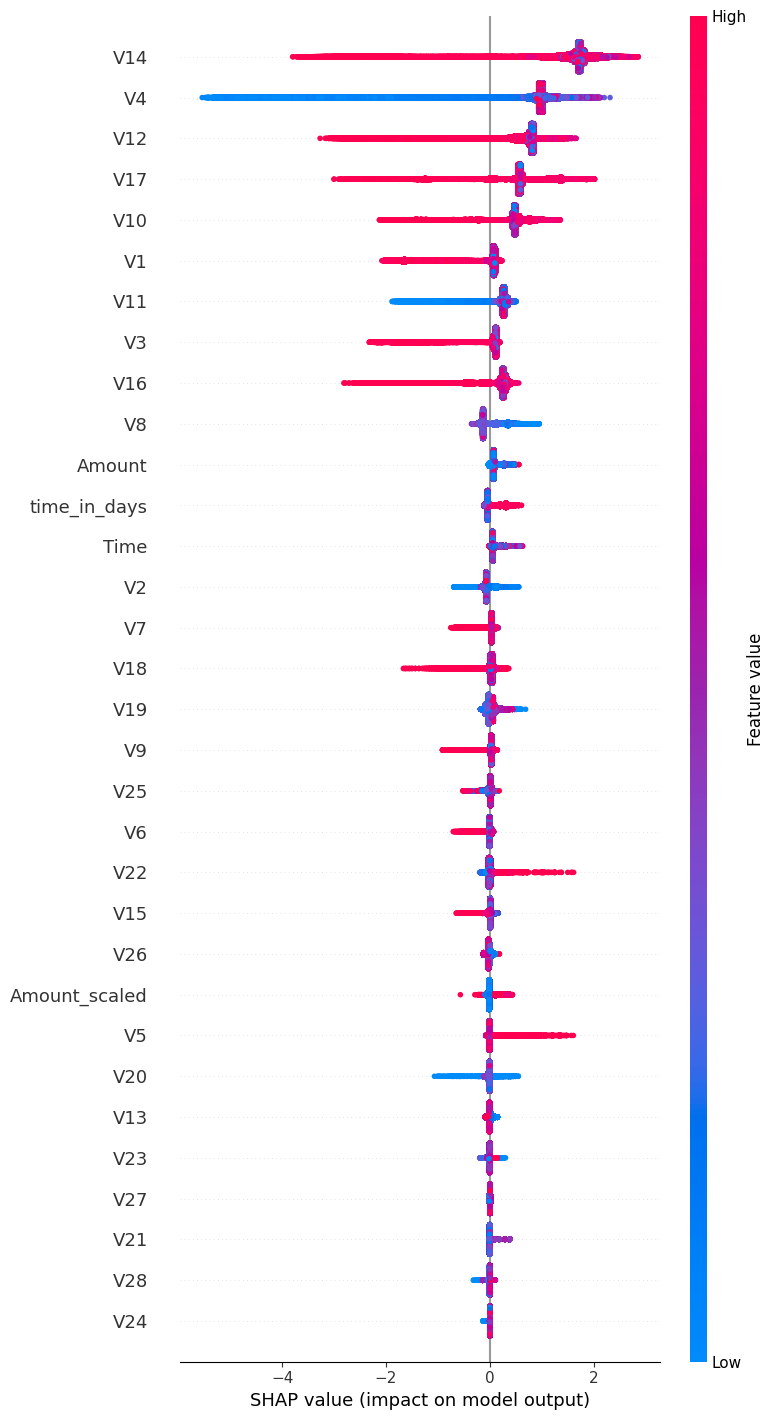

c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Model: Gradient Boosting | Accuracy: 0.6590 | Precision: 0.5963 | Recall: 0.9922 | F1 Score: 0.7449


In [ ]:
# Gradient Boosting
model_name = "Gradient Boosting"
model_path = "c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/fraud_detection/credit-model/Gradient Boosting.joblib"  
model = joblib.load(model_path)

log_experiment_with_shap(
    model_name=model_name,
    model=model,
    X_train=X_train,         
    X_test=X_test,          
    y_train=y_train,         
    y_test=y_test,          
    params={"n_estimators": 100, "learning_rate": 0.1}
)

### Model Explanability using Lime

In [31]:
import mlflow
import mlflow.sklearn
from lime.lime_tabular import LimeTabularExplainer
import joblib
import numpy as np
import pandas as pd

# Disable autologging for scikit-learn to avoid conflicts
mlflow.sklearn.autolog(disable=True)

def log_experiment_with_lime(model_name, model_path, X_train, X_test, y_train, y_test, sample_index=0, params=None, show_in_notebook=True):
    # Load the pre-trained model
    model = joblib.load(model_path)
    
    # Ensure X_train and X_test are handled consistently as arrays
    if isinstance(X_train, pd.DataFrame):
        feature_names = X_train.columns.tolist()  # Get actual feature names from X_train DataFrame
        X_train_values = X_train.values
    else:
        feature_names = [f'Feature_{i}' for i in range(model.n_features_in_)]  # Placeholder names
        X_train_values = X_train

    # Use all features from X_test for explanations
    if isinstance(X_test, pd.DataFrame):
        X_test_values = X_test.values  # Get all features
        instance = X_test.iloc[sample_index].values  # Use specified sample_index
    else:
        X_test_values = X_test  # Get all features as array
        instance = X_test[sample_index]  # Use specified sample_index
    
    # Start an MLflow run
    with mlflow.start_run(run_name=model_name):
        
        # Log model parameters if provided
        if params is not None:
            mlflow.log_params(params)
        
        # Log the trained model with an input example
        input_example = np.array([X_train_values[0]])  # Use first row as an example
        mlflow.sklearn.log_model(model, model_name, input_example=input_example)
        
        # Initialize the LimeTabularExplainer with actual feature names
        explainer = LimeTabularExplainer(
            training_data=X_train_values,  # Use all training features
            mode='classification', 
            feature_names=feature_names,  # Use all feature names
            class_names=np.unique(y_train).tolist(), 
            discretize_continuous=True
        )
        
        # Generate explanation for the specified instance in X_test
        exp = explainer.explain_instance(
            instance,
            model.predict_proba,
            num_features=10  # Show all features
        )
        
        # Plot the explanation using Matplotlib
        plt.figure(figsize=(10, 5))
        exp.as_pyplot_figure()
        plt.title(f'LIME Explanation for Sample {sample_index}')
        plt.show()

        # Print some information
        print(f"Model: {model_name}")


# Ensure the sample_index you want to test is consistent across different models
sample_index = 0  # Change this index as needed for different instances

<Figure size 1000x500 with 0 Axes>

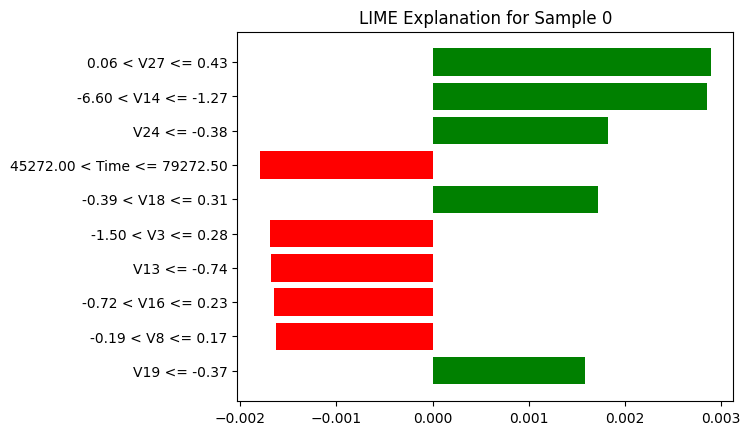

Model: Logistic Regression


In [ ]:
# Load your saved Logistic Regression model
params={"max_iter": 100}

log_experiment_with_lime(
    model_name="Logistic Regression",
    model_path='c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/fraud_detection/credit-model/Logistic Regression.joblib',
    X_train=X_train,         
    X_test=X_test,           
    y_train=y_train,         
    y_test=y_test,
    sample_index=sample_index,           
    params=params,           
    show_in_notebook=True     
)

<Figure size 1000x500 with 0 Axes>

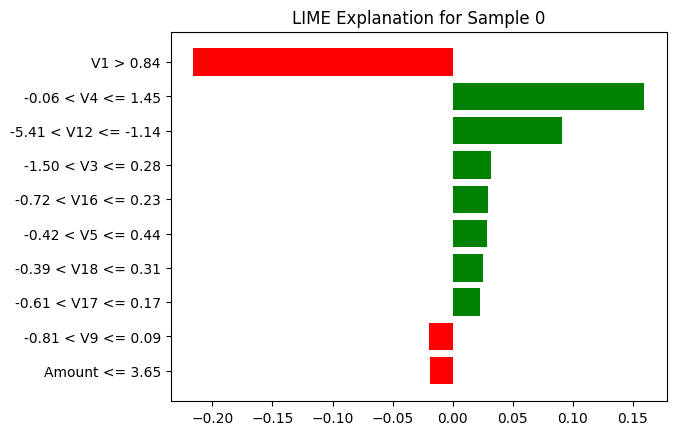

Model: Decision Tree


In [ ]:
# Load your saved Decision Tree model
params={"max_depth": 5}

log_experiment_with_lime(
    model_name="Decision Tree",
    model_path='c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/fraud_detection/credit-model/Decision Tree.joblib',
    X_train=X_train,         
    X_test=X_test,           
    y_train=y_train,         
    y_test=y_test,
    sample_index=sample_index,           
    params=params,           
    show_in_notebook=True    
)

##### Gradient Boosting

<Figure size 1000x500 with 0 Axes>

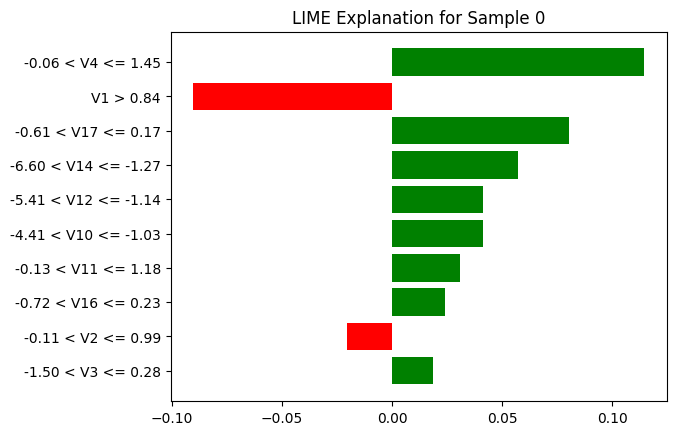

Model: Gradient_Boosting


In [ ]:
# Load your saved Gradient boosting model
params={"n_estimators": 100, "learning_rate": 0.1}

log_experiment_with_lime(
    model_name="Gradient_Boosting",
    model_path='c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/fraud_detection/credit-model/Gradient Boosting.joblib',
    X_train=X_train,         
    X_test=X_test,           
    y_train=y_train,         
    y_test=y_test,  
    sample_index=sample_index,         
    params=params,           
    show_in_notebook=True    
)

<Figure size 1000x500 with 0 Axes>

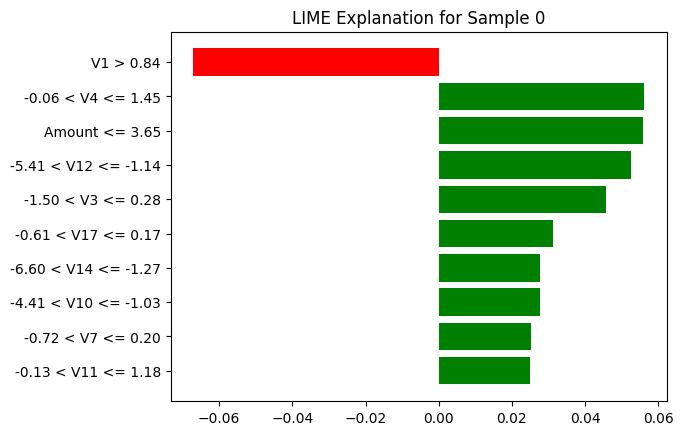

Model: RandomForestClassifier


In [ ]:
# Load your saved Random Forest model
params = {"n_estimators": 100, "max_depth": 10}

log_experiment_with_lime(
    model_name="RandomForestClassifier",
    model_path="c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/fraud_detection/credit-model/Random Forest.joblib",
    X_train=X_train,        
    X_test=X_test,          
    y_train=y_train,        
    y_test=y_test,  
    sample_index=sample_index,         
    params=params,           
    show_in_notebook=True    
)